In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
tf.test.is_gpu_available()

False

In [ ]:

import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image


In [ ]:
def normalize_image(img):
    img = 255*(img+1.0)/2.0
    return tf.cast(img,tf.uint8)

In [ ]:
import matplotlib.pyplot as plt
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [ ]:
def save_image(img,file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

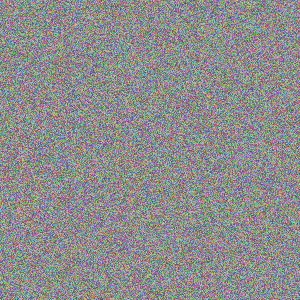

In [ ]:
img_noise = np.random.uniform(size=(300,300,3)) + 100.0
img_noise = img_noise.astype(np.float32)
show_image(normalize_image(img_noise))


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

# ***Select Layer***

Try to ues mixed1，mixed2，mixed3，mixed4，mixed5，mixed6，mixed7

In [ ]:
layer_names = 'mixed5'
layers = base_model.get_layer(layer_names).output

In [ ]:
dream_model = tf.keras.Model(inputs=base_model.input,outputs=layers)

# ***Select Channel***

Note that the value of channel should not be too large (not larger than the number of layers).

In [ ]:
channel=74

In [ ]:
def calc_loss(img,model):
    img=tf.expand_dims(img,axis=0)
    #The image is forward propagated through the model to get the computed result
    layer_activations = model(img)

    act = layer_activations[:,:,:,channel]
    loss = tf.math.reduce_mean(act)
    return loss

In [ ]:
def render_deepdream(model,img,steps=100,step_size=0.8,verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            #Apply gradient transformation to img
            tape.watch(img)
            loss = calc_loss(img,model)
        #Compute the gradient of the loss with respect to the pixels of the input image
        gradients = tape.gradient(loss,img)
        gradients /= tf.math.reduce_std(gradients) +1e-8

        img = img+gradients*step_size
        img = tf.clip_by_value(img,-1,1)

        if(verbose ==1):
            if((n+1)%10==0):
                print("Step {}/{},loss {}".format(n+1,steps,loss))
    return img

In [ ]:
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

# ***Filter style generation***

START...
Step 10/100,loss 2.6265668869018555
Step 20/100,loss 6.731013774871826
Step 30/100,loss 9.255330085754395
Step 40/100,loss 10.967744827270508
Step 50/100,loss 12.31043529510498
Step 60/100,loss 13.33114242553711
Step 70/100,loss 14.25257682800293
Step 80/100,loss 14.966536521911621
Step 90/100,loss 15.513200759887695
Step 100/100,loss 16.02537727355957
DREAM....


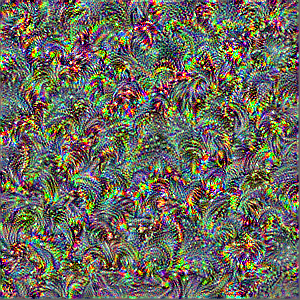

SAVE：


In [ ]:
import time

start = time.time()
print("START...")

dream_img = render_deepdream(dream_model,img,steps=100,step_size=0.05)

end = time.time()
end-start
print("DREAM....")

dream_img = normalize_image(dream_img)

show_image(dream_img)

file_name = 'deepdream_{}.jpg'.format(layer_names)
save_image(dream_img,file_name)
print("SAVE：".format(file_name))

# ***Load the image you want to create***

Please enter the url where the image can be downloaded.

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/0/09/Grass_at_a_lawn_with_morning_dew_04.jpg'

7681536/7681536 [==============================] - 0s 0us/step


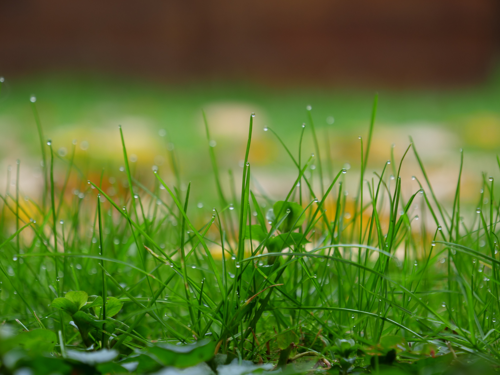

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)


  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


original_img = download(url, max_dim=500)
original_img = original_img[:, :, :3]
original_img = original_img.astype(np.uint8)
# Source code
# original_img = original_img.astype(np.float32)


show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://upload.wikimedia.org/wikipedia/commons/0/09/Grass_at_a_lawn_with_morning_dew_04.jpg">Von.grzanka</a>'))

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [ ]:
name = layer_names  # Layer name
channel_index = channel # Channel index

layer_output = base_model.get_layer(name).output
selected_channel = layer_output[:, :, :, channel_index]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=selected_channel)

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

# ***The first fusion creates***

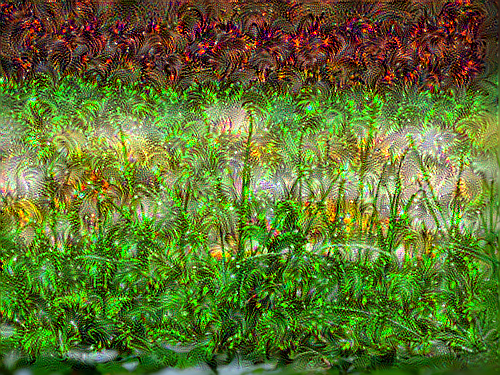

In [ ]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.03)

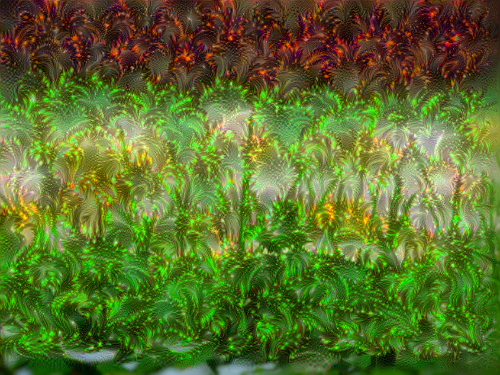

340.6112744808197

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])

  return shift, img_rolled

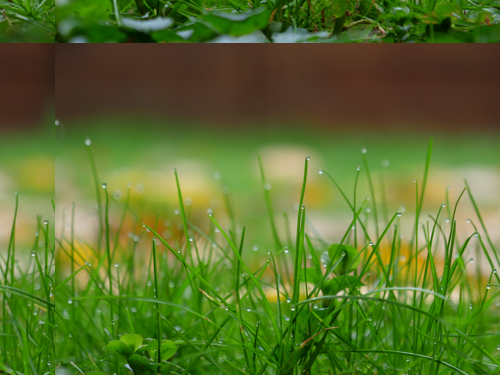

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

# ***Deep integration and creation***

Try changing the octaves=range()de range to increase the depth of the image.

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

# **Your co-creation with the machine is complete!**

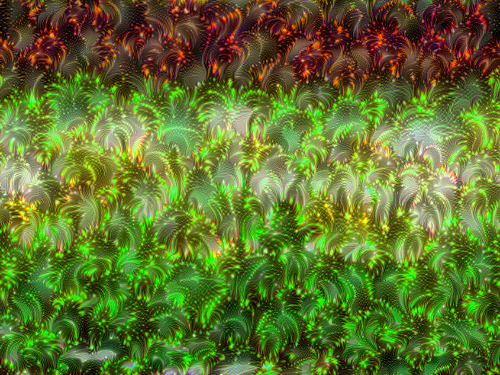

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)